In [19]:
!pip install lxml



In [20]:
!pip install mysql-connector-python

In [21]:
!pip install pyspark

In [22]:
!pip install pandas

In [23]:
# Importer les bibliothèques nécessaires
import pandas as pd
import re
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

from bs4 import BeautifulSoup
from io import StringIO
from lxml import etree


from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, BooleanType

from pyspark.sql.functions import col, count, when, length, trim, isnan, regexp_extract, udf, coalesce, lit, sum, avg, expr, upper, trim, sum as spark_sum
 

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

from matplotlib.colors import ListedColormap

### Traitement des données du fichier XML

In [24]:
# Initialiser une session Spark
spark = SparkSession.builder.appName("KaggleSparkXML").getOrCreate()
 
# Définir le chemin du fichier XML
file_path = '/kaggle/input/jeux-olympiques/olympic_hosts.xml'
 
# Lire le fichier XML
tree = etree.parse(file_path)
root = tree.getroot()
 
# Convertir les données XML en une liste de dictionnaires
data = [{child.tag: child.text for child in root[i]} for i in range(len(root))]
 
# Créer un DataFrame Spark à partir des données
host = spark.createDataFrame(data)
 
# Afficher les données
host.show()

24/05/31 05:58:34 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


+--------------------+------------------+-------------------+-----------+-------------------+--------------------+---------+-----+
|       game_end_date|     game_location|          game_name|game_season|          game_slug|     game_start_date|game_year|index|
+--------------------+------------------+-------------------+-----------+-------------------+--------------------+---------+-----+
|2022-02-20T12:00:00Z|             China|       Beijing 2022|     Winter|       beijing-2022|2022-02-04T15:00:00Z|     2022|    0|
|2021-08-08T14:00:00Z|             Japan|         Tokyo 2020|     Summer|         tokyo-2020|2021-07-23T11:00:00Z|     2020|    1|
|2018-02-25T08:00:00Z| Republic of Korea|   PyeongChang 2018|     Winter|   pyeongchang-2018|2018-02-08T23:00:00Z|     2018|    2|
|2016-08-21T21:00:00Z|            Brazil|           Rio 2016|     Summer|           rio-2016|2016-08-05T12:00:00Z|     2016|    3|
|2014-02-23T16:00:00Z|Russian Federation|         Sochi 2014|     Winter|         s

In [25]:
# Drop la col "index" 
host_no_index = host.drop("index")

# Pour que Spark ne partisionne pas la df en plusieurs csvs
host_single_partition = host_no_index.coalesce(1)

# Saauvegarder la df dans un seule csv
host_single_partition.write.format("csv").option("header", "true").mode("overwrite").save("/kaggle/working/host.csv")

### Traitement des données du fichier XML

In [26]:
file_path_html = '/kaggle/input/jeux-olympiques/olympic_results.html'

# Lire le html
with open(file_path_html, 'r') as file:
    html_content = file.read()

# Parse avec BeautifulSoup
soup = BeautifulSoup(html_content, 'lxml')

# Extraire le tableau
table = soup.find('table')

# Lire le tableau dans une df pandas
df_pandas = pd.read_html(StringIO(str(table)))[0]

# Check data types
print(df_pandas.dtypes)

Unnamed: 0                int64
discipline_title         object
event_title              object
slug_game                object
participant_type         object
medal_type               object
athletes                 object
rank_equal               object
rank_position            object
country_name             object
country_code             object
country_3_letter_code    object
athlete_url              object
athlete_full_name        object
value_unit               object
value_type               object
dtype: object


In [27]:
# Convertir les cols 
df_pandas['Unnamed: 0'] = pd.to_numeric(df_pandas['Unnamed: 0'], errors='coerce').fillna(0).astype(int)
df_pandas['rank_position'] = pd.to_numeric(df_pandas['rank_position'], errors='coerce').fillna(0).astype(int)
df_pandas['rank_equal'] = df_pandas['rank_equal'].astype(str).apply(lambda x: x.lower() in ['true', '1', 'yes'])

# Definir la schema
schema = StructType([
    StructField("Unnamed: 0", IntegerType(), True),
    StructField("discipline_title", StringType(), True),
    StructField("event_title", StringType(), True),
    StructField("slug_game", StringType(), True),
    StructField("participant_type", StringType(), True),
    StructField("medal_type", StringType(), True),
    StructField("athletes", StringType(), True),
    StructField("rank_equal", BooleanType(), True),
    StructField("rank_position", IntegerType(), True),
    StructField("country_name", StringType(), True),
    StructField("country_code", StringType(), True),
    StructField("country_3_letter_code", StringType(), True),
    StructField("athlete_url", StringType(), True),
    StructField("athlete_full_name", StringType(), True),
    StructField("value_unit", StringType(), True),
    StructField("value_type", StringType(), True)
])

# Convert the Pandas DataFrame to a Spark DataFrame using the defined schema
resultats = spark.createDataFrame(df_pandas, schema=schema)

resultats.show()

24/05/31 06:03:02 WARN TaskSetManager: Stage 28 contains a task of very large size (4944 KiB). The maximum recommended task size is 1000 KiB.


+----------+----------------+-------------+------------+----------------+----------+--------------------+----------+-------------+--------------------+------------+---------------------+-----------+-----------------+----------+----------+
|Unnamed: 0|discipline_title|  event_title|   slug_game|participant_type|medal_type|            athletes|rank_equal|rank_position|        country_name|country_code|country_3_letter_code|athlete_url|athlete_full_name|value_unit|value_type|
+----------+----------------+-------------+------------+----------------+----------+--------------------+----------+-------------+--------------------+------------+---------------------+-----------+-----------------+----------+----------+
|         0|         Curling|Mixed Doubles|beijing-2022|        GameTeam|      GOLD|[('Stefania CONST...|     false|            1|               Italy|          IT|                  ITA|        NaN|              NaN|       NaN|       NaN|
|         1|         Curling|Mixed Doubles|b

### Vérifiez le nombre de valeurs manquantes dans chaque colonne du fichier résultats

24/05/31 06:03:03 WARN TaskSetManager: Stage 29 contains a task of very large size (4943 KiB). The maximum recommended task size is 1000 KiB.
24/05/31 06:03:07 WARN TaskSetManager: Stage 32 contains a task of very large size (4943 KiB). The maximum recommended task size is 1000 KiB.


+----------+----------------+-----------+---------+----------------+----------+--------+-------------+------------+------------+---------------------+-----------+-----------------+----------+----------+
|Unnamed: 0|discipline_title|event_title|slug_game|participant_type|medal_type|athletes|rank_position|country_name|country_code|country_3_letter_code|athlete_url|athlete_full_name|value_unit|value_type|
+----------+----------------+-----------+---------+----------------+----------+--------+-------------+------------+------------+---------------------+-----------+-----------------+----------+----------+
|         0|               0|          0|        0|               0|    142598|  154828|            0|           0|        5036|                    0|      32813|            21158|     84158|     72755|
+----------+----------------+-----------+---------+----------------+----------+--------+-------------+------------+------------+---------------------+-----------+-----------------+--------

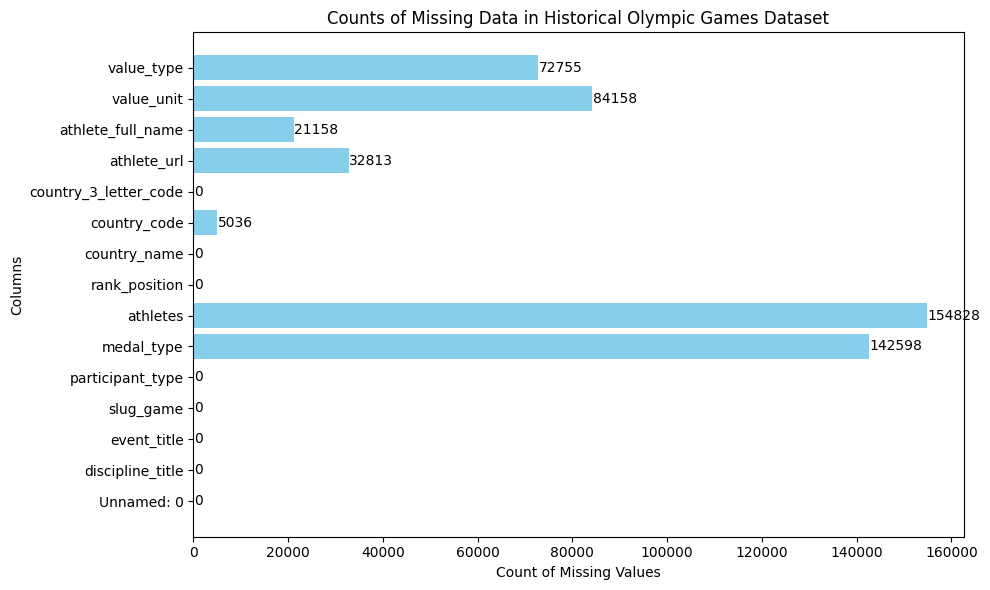

In [28]:
# Créer une liste de colonnes à exclure de la vérification NaN
boolean_cols = [c for c in resultats.columns if resultats.schema[c].dataType == BooleanType()]

# Comptez le nombre de NaN/nulls/vides dans chaque colonne
nan_counts_exprs = [
    count(when(col(c).isNull() | isnan(col(c)) | (col(c) == ""), c)).alias(c)
    for c in resultats.columns if c not in boolean_cols
]

# Afficher le résultat
nan_counts_spark_df = resultats.agg(*nan_counts_exprs)
nan_counts_spark_df.show()

# Convertissez la df Spark en df Pandas pour un traçage plus facile
nan_counts_df = nan_counts_spark_df.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(nan_counts_df.columns, nan_counts_df.iloc[0], color='skyblue')


for i, v in enumerate(nan_counts_df.iloc[0]):
    plt.text(v + 100, i, str(v), va='center')

plt.xlabel('Count of Missing Values')
plt.ylabel('Columns')
plt.title('Counts of Missing Data in Historical Olympic Games Dataset')
plt.tight_layout()  
plt.savefig('missing_data_counts.png')  # Save the plot as an image
plt.show()



#### Une partie d'exploration de données dans laquelle nous avons essayé de voir quelles sont les valeurs dans certaines colonnes qui ne nous étaient pas claires (value_type, valu_unit)

In [29]:
unique_values = resultats.select('value_type').distinct().collect()

# Print or display the unique values
for row in unique_values:
    print(row[0]) 

24/05/31 06:03:11 WARN TaskSetManager: Stage 35 contains a task of very large size (4943 KiB). The maximum recommended task size is 1000 KiB.


IRM
STROKES
POINTS
IRM_POINTS
WEIGHT
SC_REST$IRM
TIME
NaN
CODE
DISTANCE
NO_TIME
RANK
SCORE


In [30]:
unique_values = resultats.select('value_unit').distinct().collect()

# # Print or display the unique values
# for row in unique_values:
#     print(row[0]) 

24/05/31 06:03:12 WARN TaskSetManager: Stage 38 contains a task of very large size (4943 KiB). The maximum recommended task size is 1000 KiB.


In [31]:

# Drop value_unit et value_type
resultats = resultats.drop('value_unit', 'value_type')

# resultats = resultats.withColumn('medal_type', coalesce(col('medal_type'), lit(0)))


resultats.show()


24/05/31 06:03:14 WARN TaskSetManager: Stage 41 contains a task of very large size (4944 KiB). The maximum recommended task size is 1000 KiB.


+----------+----------------+-------------+------------+----------------+----------+--------------------+----------+-------------+--------------------+------------+---------------------+-----------+-----------------+
|Unnamed: 0|discipline_title|  event_title|   slug_game|participant_type|medal_type|            athletes|rank_equal|rank_position|        country_name|country_code|country_3_letter_code|athlete_url|athlete_full_name|
+----------+----------------+-------------+------------+----------------+----------+--------------------+----------+-------------+--------------------+------------+---------------------+-----------+-----------------+
|         0|         Curling|Mixed Doubles|beijing-2022|        GameTeam|      GOLD|[('Stefania CONST...|     false|            1|               Italy|          IT|                  ITA|        NaN|              NaN|
|         1|         Curling|Mixed Doubles|beijing-2022|        GameTeam|    SILVER|[('Kristin SKASLI...|     false|            2|  

### On remplace nan par 0 dans la colonne Medal_type

In [32]:
resultats = resultats.withColumn("medal_type", when(col("medal_type").isNull(), 0)
                                             .when(isnan(col("medal_type")), 0)
                                             .when(col("medal_type") == "", 0)
                                             .otherwise(col("medal_type")))

resultats.select("medal_type").distinct().show()



24/05/31 06:03:15 WARN TaskSetManager: Stage 42 contains a task of very large size (4943 KiB). The maximum recommended task size is 1000 KiB.


+----------+
|medal_type|
+----------+
|         0|
|    SILVER|
|      GOLD|
|    BRONZE|
+----------+



In [33]:
# Regroupez les données par nom complet de l'athlète et comptez les occurrences
athlete_name_counts = resultats.groupBy('athlete_full_name').count()

# Filtrez les données pour trouver des noms avec plus d'une occurrence
duplicate_names = athlete_name_counts.filter(col('count') > 1)

duplicate_names.show()


24/05/31 06:03:16 WARN TaskSetManager: Stage 45 contains a task of very large size (4943 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+-----+
|   athlete_full_name|count|
+--------------------+-----+
|     Ashley CALDWELL|    4|
|    Cynthia MASCITTO|    3|
|       Edwin CORATTI|    2|
|          Roman REES|    4|
| Elvedina MUZAFERIJA|    8|
|       Richard JOUVE|    3|
|       Jesper HANSEN|    3|
|      Rommel PACHECO|    5|
|Anamaria GOVORCIN...|    2|
|    Mohamed SAADAOUI|    2|
|          Maja JAGER|    2|
|      Karim LAGHOUAG|    2|
|          Mary HANNA|    6|
|           Ese BRUME|    2|
|          Koen NAERT|    2|
|     Sandra PERKOVIC|    3|
|   Christopher LINKE|    3|
|   Karl-Martin RAMMO|    3|
|  Marie DORIN HABERT|   10|
|         Elena KOENZ|    3|
+--------------------+-----+
only showing top 20 rows



In [34]:
resultats = resultats.drop('athletes', 'country_code')
resultats.show()

 

24/05/31 06:03:18 WARN TaskSetManager: Stage 48 contains a task of very large size (4944 KiB). The maximum recommended task size is 1000 KiB.


+----------+----------------+-------------+------------+----------------+----------+----------+-------------+--------------------+---------------------+-----------+-----------------+
|Unnamed: 0|discipline_title|  event_title|   slug_game|participant_type|medal_type|rank_equal|rank_position|        country_name|country_3_letter_code|athlete_url|athlete_full_name|
+----------+----------------+-------------+------------+----------------+----------+----------+-------------+--------------------+---------------------+-----------+-----------------+
|         0|         Curling|Mixed Doubles|beijing-2022|        GameTeam|      GOLD|     false|            1|               Italy|                  ITA|        NaN|              NaN|
|         1|         Curling|Mixed Doubles|beijing-2022|        GameTeam|    SILVER|     false|            2|              Norway|                  NOR|        NaN|              NaN|
|         2|         Curling|Mixed Doubles|beijing-2022|        GameTeam|    BRONZE| 

### Pour enregistrer la df dans un seul document CSV

In [35]:
df_single_partition = resultats.coalesce(1)


df_single_partition.write.format("csv").option("header", "true").mode("overwrite").save("/kaggle/working/df8.csv")

24/05/31 06:03:18 WARN TaskSetManager: Stage 49 contains a task of very large size (19553 KiB). The maximum recommended task size is 1000 KiB.


In [36]:

df = resultats.select('country_name', 'medal_type', 'rank_position')

# Attribuer des poids aux médailles
medal_weights = df.withColumn(
    'medal_weight',
    when(col('medal_type') == 'GOLD', 3)
    .when(col('medal_type') == 'SILVER', 2)
    .when(col('medal_type') == 'BRONZE', 1)
    .otherwise(0)
)

# Regroupez les données pour obtenir le nombre de médailles et le nombre de participants pour chaque pays
medal_counts = df.groupBy('country_name').agg(
    sum(when(col('medal_type').isin('GOLD', 'SILVER', 'BRONZE'), 1).otherwise(0)).alias('total_medals'),
    sum(when(col('medal_type') == 'GOLD', 1).otherwise(0)).alias('gold_medals'),
    sum(when(col('medal_type') == 'SILVER', 1).otherwise(0)).alias('silver_medals'),
    sum(when(col('medal_type') == 'BRONZE', 1).otherwise(0)).alias('bronze_medals'),
    count('rank_position').alias('total_participants')
)

# Calculer la position pondérée dans le classement et les 10 premiers classements
rank_stats = medal_weights.groupBy('country_name').agg(
    sum('rank_position').alias('total_rank_position'),
    sum('medal_weight').alias('total_medal_weight'),
    sum(when(col('rank_position') <= 10, 1).otherwise(0)).alias('top_10_finishes')
)

# Rejoignez le décompte des médailles et les statistiques de classement
performance_metrics = medal_counts.join(rank_stats, on='country_name')

# Calculer la position moyenne pondérée du classement (en tenant compte du poids des médailles)
performance_metrics = performance_metrics.withColumn(
    'avg_rank_position_weighted',
    (col('total_rank_position') + col('total_medal_weight')) / col('total_participants')
)

# Normalizer les top 10
performance_metrics = performance_metrics.withColumn(
    'top_10_finishes_normalized',
    col('top_10_finishes') / col('total_participants')
)


performance_metrics.show()

from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(
    inputCols=['total_medals', 'gold_medals', 'silver_medals', 'bronze_medals', 'avg_rank_position_weighted', 'top_10_finishes_normalized'],
    outputCol='features'
)
assembled_data = assembler.transform(performance_metrics)



24/05/31 06:03:21 WARN TaskSetManager: Stage 50 contains a task of very large size (4943 KiB). The maximum recommended task size is 1000 KiB.
24/05/31 06:03:22 WARN TaskSetManager: Stage 51 contains a task of very large size (4943 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+------------+-----------+-------------+-------------+------------------+-------------------+------------------+---------------+--------------------------+--------------------------+
|        country_name|total_medals|gold_medals|silver_medals|bronze_medals|total_participants|total_rank_position|total_medal_weight|top_10_finishes|avg_rank_position_weighted|top_10_finishes_normalized|
+--------------------+------------+-----------+-------------+-------------+------------------+-------------------+------------------+---------------+--------------------------+--------------------------+
|       Côte d'Ivoire|           1|          0|            0|            1|                 9|                 87|                 1|              6|         9.777777777777779|        0.6666666666666666|
|                Chad|           0|          0|            0|            0|                11|                154|                 0|              4|                      14.0|       0

24/05/31 06:03:25 WARN TaskSetManager: Stage 56 contains a task of very large size (4943 KiB). The maximum recommended task size is 1000 KiB.
24/05/31 06:03:26 WARN TaskSetManager: Stage 57 contains a task of very large size (4943 KiB). The maximum recommended task size is 1000 KiB.
24/05/31 06:03:28 WARN TaskSetManager: Stage 60 contains a task of very large size (4943 KiB). The maximum recommended task size is 1000 KiB.
24/05/31 06:03:29 WARN TaskSetManager: Stage 61 contains a task of very large size (4943 KiB). The maximum recommended task size is 1000 KiB.
24/05/31 06:03:31 WARN TaskSetManager: Stage 69 contains a task of very large size (4943 KiB). The maximum recommended task size is 1000 KiB.
24/05/31 06:03:32 WARN TaskSetManager: Stage 70 contains a task of very large size (4943 KiB). The maximum recommended task size is 1000 KiB.
24/05/31 06:03:35 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/05/31 06:03:36 WARN TaskSetManager: St

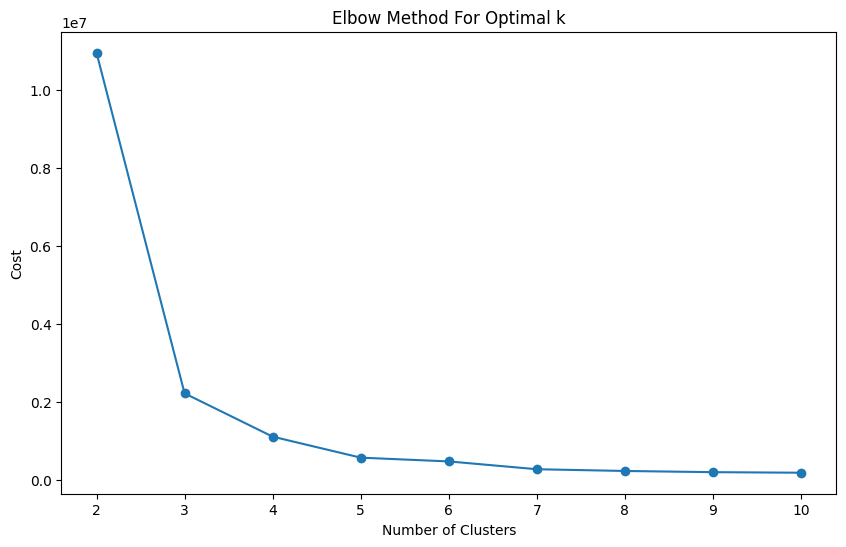

In [37]:


# Elbow method 
cost = []
for k in range(2, 11):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('features')
    model = kmeans.fit(assembled_data)
    predictions = model.transform(assembled_data)
    evaluator = ClusteringEvaluator(featuresCol='features', predictionCol='prediction', metricName='silhouette')
    silhouette = evaluator.evaluate(predictions)
    cost.append(model.summary.trainingCost)
    
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), cost, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()


In [38]:
optimal_k = 4  

kmeans = KMeans(k=optimal_k, seed=1, featuresCol='features', predictionCol='cluster')
model = kmeans.fit(assembled_data)

predictions = model.transform(assembled_data)

evaluator = ClusteringEvaluator(featuresCol='features', predictionCol='cluster')
silhouette = evaluator.evaluate(predictions)
print(f'Silhouette with squared euclidean distance: {silhouette}')

predictions.select('country_name', 'cluster').show()



24/05/31 06:05:20 WARN TaskSetManager: Stage 639 contains a task of very large size (4943 KiB). The maximum recommended task size is 1000 KiB.
24/05/31 06:05:21 WARN TaskSetManager: Stage 640 contains a task of very large size (4943 KiB). The maximum recommended task size is 1000 KiB.
24/05/31 06:05:22 WARN TaskSetManager: Stage 648 contains a task of very large size (4943 KiB). The maximum recommended task size is 1000 KiB.
24/05/31 06:05:23 WARN TaskSetManager: Stage 649 contains a task of very large size (4943 KiB). The maximum recommended task size is 1000 KiB.
24/05/31 06:05:24 WARN TaskSetManager: Stage 673 contains a task of very large size (4943 KiB). The maximum recommended task size is 1000 KiB.
24/05/31 06:05:25 WARN TaskSetManager: Stage 674 contains a task of very large size (4943 KiB). The maximum recommended task size is 1000 KiB.
24/05/31 06:05:27 WARN TaskSetManager: Stage 682 contains a task of very large size (4943 KiB). The maximum recommended task size is 1000 KiB.

Silhouette with squared euclidean distance: 0.9487893795589097


24/05/31 06:05:31 WARN TaskSetManager: Stage 698 contains a task of very large size (4943 KiB). The maximum recommended task size is 1000 KiB.
24/05/31 06:05:32 WARN TaskSetManager: Stage 699 contains a task of very large size (4943 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+-------+
|        country_name|cluster|
+--------------------+-------+
|       Côte d'Ivoire|      0|
|                Chad|      0|
|            Paraguay|      0|
|               Yemen|      0|
|      Chinese Taipei|      0|
|Islamic Republic ...|      0|
|             Senegal|      0|
|              Sweden|      2|
|            Kiribati|      0|
|   Republic of Korea|      2|
|              Guyana|      0|
|         Philippines|      0|
|             Eritrea|      0|
|               Tonga|      0|
|            Djibouti|      0|
|            Malaysia|      0|
|           Singapore|      0|
|                Fiji|      0|
|              Turkey|      0|
|              Malawi|      0|
+--------------------+-------+
only showing top 20 rows



24/05/31 06:05:33 WARN TaskSetManager: Stage 704 contains a task of very large size (4943 KiB). The maximum recommended task size is 1000 KiB.
24/05/31 06:05:34 WARN TaskSetManager: Stage 705 contains a task of very large size (4943 KiB). The maximum recommended task size is 1000 KiB.
24/05/31 06:05:35 WARN TaskSetManager: Stage 710 contains a task of very large size (4943 KiB). The maximum recommended task size is 1000 KiB.
24/05/31 06:05:36 WARN TaskSetManager: Stage 711 contains a task of very large size (4943 KiB). The maximum recommended task size is 1000 KiB.
/tmp/ipykernel_33/1080255387.py:9: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


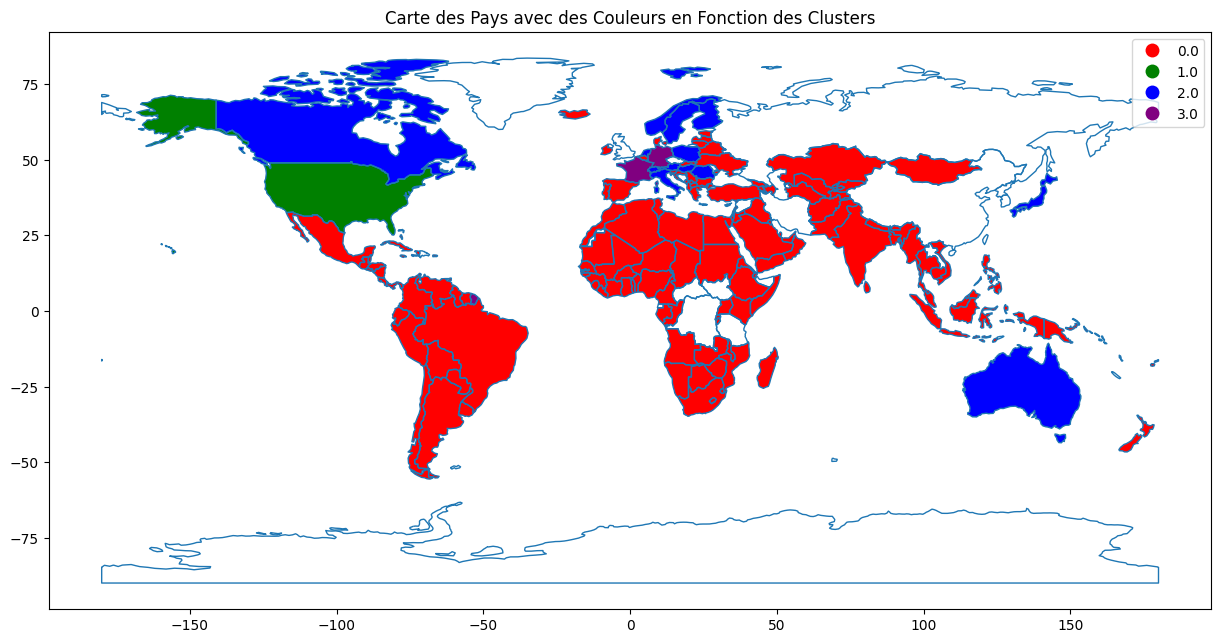

In [39]:

# Convertir les Spark DataFrames en Pandas DataFrames
performance_metrics_pd = performance_metrics.toPandas()
predictions_pd = predictions.select('country_name', 'cluster').toPandas()

# Joindre les métriques de performance avec les prédictions de clusters
performance_with_clusters_pd = performance_metrics_pd.merge(predictions_pd, on='country_name')

# Charger les frontières des pays à partir d'un fichier GeoJSON
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Assurez-vous que les noms des pays correspondent entre votre dataframe et les données géographiques
performance_with_clusters_pd['country_name'] = performance_with_clusters_pd['country_name'].str.upper()
world['name'] = world['name'].str.upper()

# Joindre les clusters aux données géographiques
world = world.merge(performance_with_clusters_pd, left_on='name', right_on='country_name', how='left')

# Définir une palette de couleurs pour les clusters
num_clusters = performance_with_clusters_pd['cluster'].nunique()
colors = ListedColormap(['red', 'green', 'blue', 'purple'])

# Créer la carte avec des couleurs en fonction des clusters
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax, linewidth=1)
world.dropna(subset=['cluster']).plot(column='cluster', cmap=colors, legend=True, ax=ax, categorical=True)
ax.set_title('Carte des Pays avec des Couleurs en Fonction des Clusters')
plt.show()


In [40]:
# Lister les pays de JO
unique_countries = sorted(performance_with_clusters_pd['country_name'].unique())
print("Countries in JO data (sorted alphabetically):")
for country in unique_countries:
    print(country)



Countries in JO data (sorted alphabetically):
AFGHANISTAN
ALBANIA
ALGERIA
AMERICAN SAMOA
ANDORRA
ANGOLA
ANTIGUA AND BARBUDA
ARGENTINA
ARMENIA
ARUBA
AUSTRALASIA
AUSTRALIA
AUSTRIA
AZERBAIJAN
BAHAMAS
BAHRAIN
BANGLADESH
BARBADOS
BELARUS
BELGIUM
BELIZE
BENIN
BERMUDA
BHUTAN
BOHEMIA
BOLIVIA
BOSNIA AND HERZEGOVINA
BOTSWANA
BRAZIL
BRITISH VIRGIN ISLANDS
BRUNEI
BULGARIA
BURKINA FASO
BURUNDI
CAMBODIA
CAMEROON
CANADA
CAPE VERDE
CAYMAN ISLANDS
CENTRAL AFRICAN REPUBLIC
CHAD
CHILE
CHINESE TAIPEI
COLOMBIA
COMOROS
CONGO
COOK ISLANDS
COSTA RICA
CROATIA
CUBA
CYPRUS
CZECH REPUBLIC
CZECHOSLOVAKIA
CÔTE D'IVOIRE
DEMOCRATIC PEOPLE'S REPUBLIC OF KOREA
DEMOCRATIC REPUBLIC OF THE CONGO
DEMOCRATIC REPUBLIC OF TIMOR-LESTE
DENMARK
DJIBOUTI
DOMINICA
DOMINICAN REPUBLIC
ECUADOR
EGYPT
EL SALVADOR
EQUATORIAL GUINEA
ERITREA
ESTONIA
ESWATINI
ETHIOPIA
FEDERAL REPUBLIC OF GERMANY
FEDERATED STATES OF MICRONESIA
FIJI
FINLAND
FRANCE
GABON
GAMBIA
GEORGIA
GERMAN DEMOCRATIC REPUBLIC (GERMANY)
GERMANY
GHANA
GREAT BRITAIN
GREECE
GR

In [41]:
# Lister les pays de GeoJSON 
unique_geojson_countries = sorted(world['name'].unique())
print("\nCountries in the GeoJSON file (sorted alphabetically):")
for country in unique_geojson_countries:
    print(country)




Countries in the GeoJSON file (sorted alphabetically):
AFGHANISTAN
ALBANIA
ALGERIA
ANGOLA
ANTARCTICA
ARGENTINA
ARMENIA
AUSTRALIA
AUSTRIA
AZERBAIJAN
BAHAMAS
BANGLADESH
BELARUS
BELGIUM
BELIZE
BENIN
BHUTAN
BOLIVIA
BOSNIA AND HERZ.
BOTSWANA
BRAZIL
BRUNEI
BULGARIA
BURKINA FASO
BURUNDI
CAMBODIA
CAMEROON
CANADA
CENTRAL AFRICAN REP.
CHAD
CHILE
CHINA
COLOMBIA
CONGO
COSTA RICA
CROATIA
CUBA
CYPRUS
CZECHIA
CÔTE D'IVOIRE
DEM. REP. CONGO
DENMARK
DJIBOUTI
DOMINICAN REP.
ECUADOR
EGYPT
EL SALVADOR
EQ. GUINEA
ERITREA
ESTONIA
ESWATINI
ETHIOPIA
FALKLAND IS.
FIJI
FINLAND
FR. S. ANTARCTIC LANDS
FRANCE
GABON
GAMBIA
GEORGIA
GERMANY
GHANA
GREECE
GREENLAND
GUATEMALA
GUINEA
GUINEA-BISSAU
GUYANA
HAITI
HONDURAS
HUNGARY
ICELAND
INDIA
INDONESIA
IRAN
IRAQ
IRELAND
ISRAEL
ITALY
JAMAICA
JAPAN
JORDAN
KAZAKHSTAN
KENYA
KOSOVO
KUWAIT
KYRGYZSTAN
LAOS
LATVIA
LEBANON
LESOTHO
LIBERIA
LIBYA
LITHUANIA
LUXEMBOURG
MADAGASCAR
MALAWI
MALAYSIA
MALI
MAURITANIA
MEXICO
MOLDOVA
MONGOLIA
MONTENEGRO
MOROCCO
MOZAMBIQUE
MYANMAR
N. CYPRUS
NAM

### Certains pays n'étaient pas représentés sur la carte. C'est pour cette raison que j'ai fait le mappage manuel

In [42]:
# Manually create a mapping for country name adjustments
country_name_mapping = {
    "BOSNIA AND HERZEGOVINA": "BOSNIA AND HERZ.",
    "CENTRAL AFRICAN REPUBLIC": "CENTRAL AFRICAN REP.",
    "CHINESE TAIPEI": "TAIWAN",
    "CZECH REPUBLIC": "CZECHIA",
    "DEMOCRATIC PEOPLE'S REPUBLIC OF KOREA": "NORTH KOREA",
    "DEMOCRATIC REPUBLIC OF THE CONGO": "DEM. REP. CONGO",
    "EQUATORIAL GUINEA": "EQ. GUINEA",
    "DOMINICAN REPUBLIC": "DOMINICAN REP.",
    "ISLAMIC REPUBLIC OF IRAN": "IRAN",
    "LAO PEOPLE'S DEMOCRATIC REPUBLIC": "LAOS",
    "PEOPLE'S REPUBLIC OF CHINA": "CHINA",
    "REPUBLIC OF MOLDOVA" : "MOLDOVA",
    "RUSSIAN FEDERATION": "RUSSIA",
    "SOUTH SUDAN": "S. SUDAN",
    "SOLOMON ISLANDS": "SOLOMON IS.",
    "SYRIAN ARAB REPUBLIC": "SYRIA",
    "GREAT BRITAIN": "UNITED KINGDOM"
}



Unmatched countries after mapping: ['KIRIBATI' 'REPUBLIC OF KOREA' 'TONGA' 'SINGAPORE' 'COMOROS' 'MALDIVES'
 'IVORY COAST' 'PALAU' 'DOMINICA' 'BRITISH VIRGIN ISLANDS'
 'HONG KONG, CHINA' 'SAN MARINO' 'KOREA TEAM' 'MALTA' 'AMERICAN SAMOA'
 'SAO TOME AND PRINCIPE' 'MARSHALL ISLANDS' 'TUVALU'
 'REFUGEE OLYMPIC TEAM' 'UNITED REPUBLIC OF TANZANIA' 'CAYMAN ISLANDS'
 'ANDORRA' 'NETHERLANDS ANTILLES' 'BARBADOS' 'LIECHTENSTEIN' 'SWAZILAND'
 'MONACO' 'CAPE VERDE' 'REFUGEE OLYMPIC ATHLETES' 'NAURU'
 'OLYMPIC ATHLETES FROM RUSSIA' 'SAINT KITTS AND NEVIS'
 'VIRGIN ISLANDS, BRITISH' 'ARUBA' 'SAINT VINCENT AND THE GRENADINES'
 'GUAM' 'GRENADA' 'FEDERATED STATES OF MICRONESIA' 'SAINT LUCIA'
 'US VIRGIN ISLANDS' 'THE FORMER YUGOSLAV REPUBLIC OF MACEDONIA'
 'SEYCHELLES' 'SAMOA' 'COOK ISLANDS' 'INDEPENDENT OLYMPIC ATHLETES'
 'ANTIGUA AND BARBUDA' 'BERMUDA' 'BAHRAIN' 'ROC'
 'DEMOCRATIC REPUBLIC OF TIMOR-LESTE' 'MAURITIUS' 'VIRGIN ISLANDS, US'
 'SERBIA AND MONTENEGRO' 'CZECHOSLOVAKIA' 'UNIFIED TEAM' 'SOVIE

/tmp/ipykernel_33/480696346.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


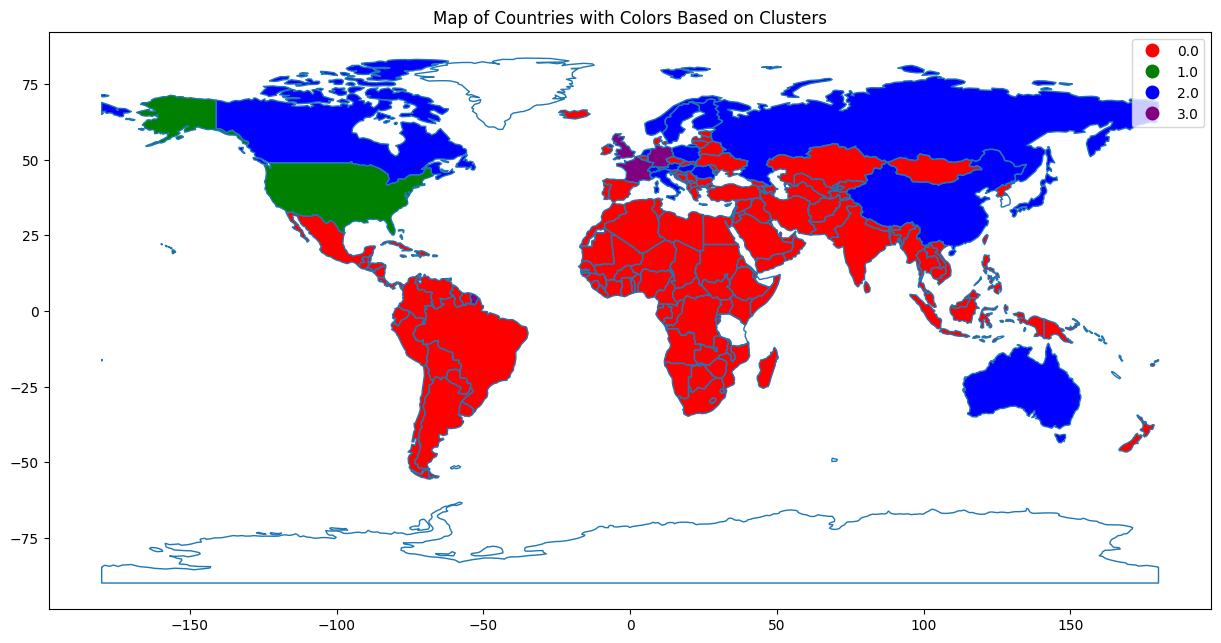

In [43]:
# Charger les limites des pays à partir d'un fichier GeoJSON
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# On s'assure que les noms de pays sont en majuscules pour plus de cohérence
performance_with_clusters_pd['country_name'] = performance_with_clusters_pd['country_name'].str.upper()
world['name'] = world['name'].str.upper()


performance_with_clusters_pd['country_name'] = performance_with_clusters_pd['country_name'].replace(country_name_mapping)

# Fusionner des clusters avec des données géographiques
world = world.merge(performance_with_clusters_pd, left_on='name', right_on='country_name', how='left')

# Étape de débogage : imprimer les pays sans correspondance
unmatched_countries = performance_with_clusters_pd[~performance_with_clusters_pd['country_name'].isin(world['name'])]['country_name'].unique()
print("Unmatched countries after mapping:", unmatched_countries)

# Définir une palette de couleurs pour les clusters
num_clusters = performance_with_clusters_pd['cluster'].nunique()
colors = ListedColormap(['red', 'green', 'blue', 'purple'])

# Créer une carte avec des couleurs basées sur des clusters
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax, linewidth=1)
world.dropna(subset=['cluster']).plot(column='cluster', cmap=colors, legend=True, ax=ax, categorical=True)
ax.set_title('Map of Countries with Colors Based on Clusters')
plt.savefig('map_clusters.png')
plt.show()


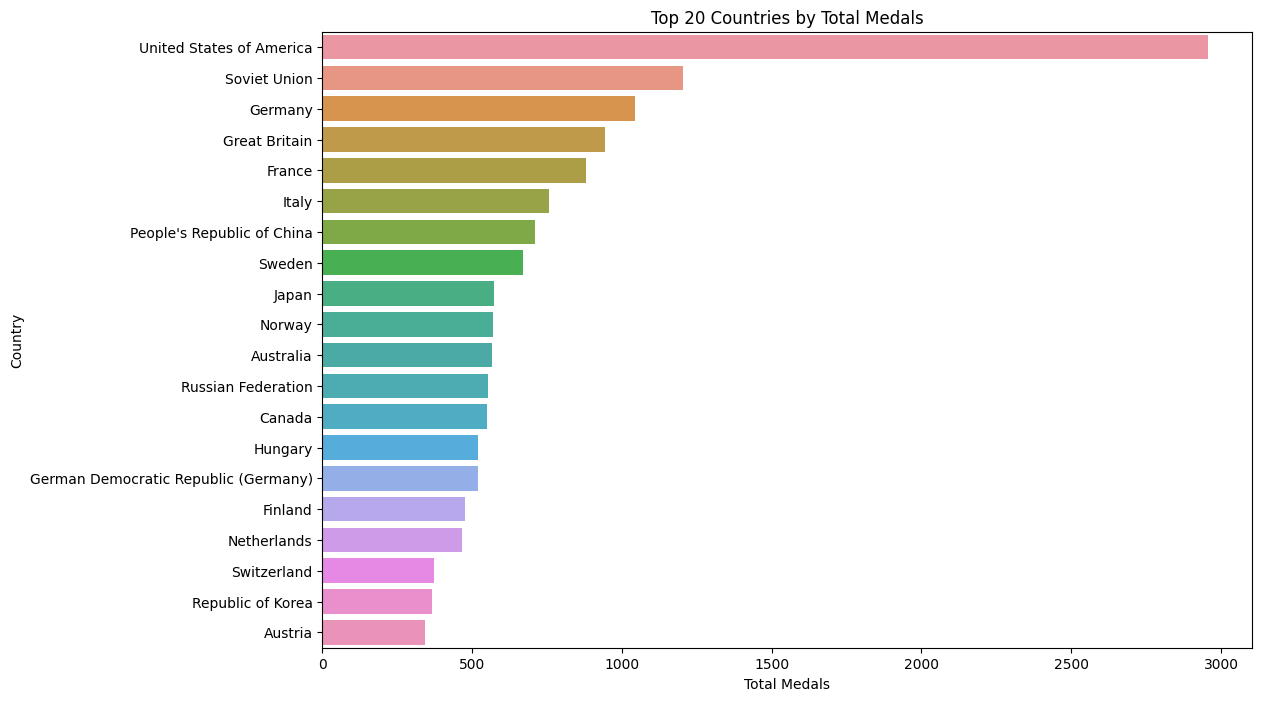

In [44]:
plt.figure(figsize=(12, 8))
sns.barplot(x='total_medals', y='country_name', data=performance_metrics_pd.sort_values('total_medals', ascending=False).head(20))
plt.xlabel('Total Medals')
plt.ylabel('Country')
plt.title('Top 20 Countries by Total Medals')
plt.savefig('top_countries.png')
plt.show()

Countries with zero population data:
['TAIWAN, CHINA', 'SLOVAKIA', 'HONG KONG, CHINA', 'REFUGEE OLYMPIC TEAM', 'REFUGEE OLYMPIC ATHLETES', 'VENEZUELA', 'OLYMPIC ATHLETES FROM RUSSIA', 'COOK ISLANDS', 'INDEPENDENT OLYMPIC ATHLETES', 'ROC', 'DEMOCRATIC REPUBLIC OF TIMOR-LESTE', 'VIRGIN ISLANDS, US', 'SERBIA AND MONTENEGRO', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
      country_name  total_medals  population  medals_per_million
97   LIECHTENSTEIN            10     39039.0          256.154102
86          NORWAY           568   5408320.0          105.023371
46      SAN MARINO             3     33745.0           88.902060
53         FINLAND           477   5541017.0           86.085280
7           SWEDEN           671  10415811.0           64.421292
206        HUNGARY           519   9709891.0           53.450652
144    SWITZERLAND           371   8703405.0           42.626995
61    BAHAMAS, THE            16    407906.0           39.224723
1

/tmp/ipykernel_33/2801154465.py:100: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  performance_with_population['medals_per_million'].fillna(0, inplace=True)


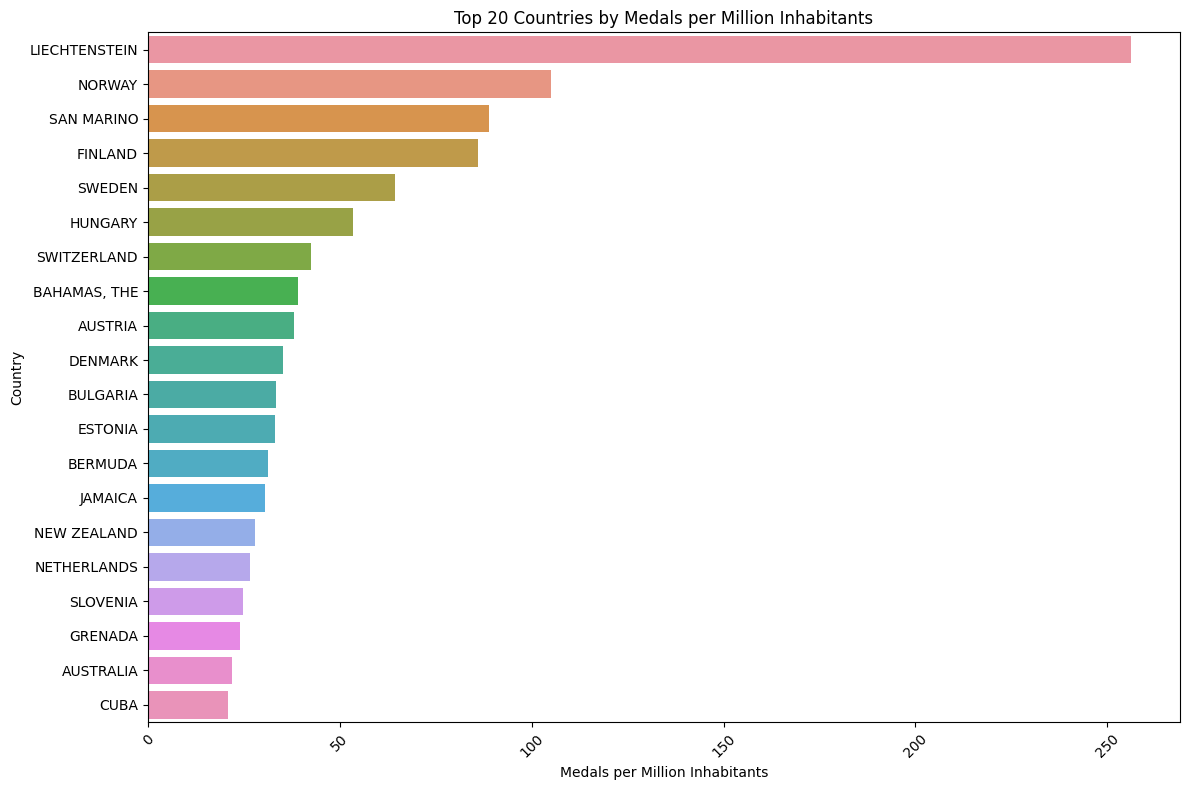

In [54]:
# Fetch population 
url = 'https://raw.githubusercontent.com/datasets/population/master/data/population.csv'
population_df = pd.read_csv(url)

# Filtrer les données de population pour l'année disponible la plus récente
population_df = population_df[population_df['Year'] == population_df['Year'].max()]

# Rennomer les cols
population_df.rename(columns={'Country Name': 'country_name', 'Value': 'population'}, inplace=True)

# Majuscule
population_df['country_name'] = population_df['country_name'].str.upper()

# mapping
country_name_mapping = {
    "IVORY COAST": "COTE D'IVOIRE",
    "YEMEN": "YEMEN, REP.",
    "CHINESE TAIPEI": "TAIWAN, CHINA",
    "ISLAMIC REPUBLIC OF IRAN": "IRAN, ISLAMIC REP.",
    "SOUTH KOREA": "KOREA, REP.",
    "TURKEY": "TURKIYE",
    "GREAT BRITAIN": "UNITED KINGDOM",
    "KOREA TEAM": "KOREA, REP.",
    "BAHAMAS": "BAHAMAS, THE",
    "UNITED REPUBLIC OF TANZANIA": "TANZANIA",
    "NETHERLANDS ANTILLES": "CURACAO",
    "RUSSIA": "RUSSIAN FEDERATION",
    "CONGO": "CONGO, REP.",
    "SWAZILAND": "ESWATINI",
    "DEMOCRATIC REPUBLIC OF THE CONGO": "CONGO, DEM. REP.",
    "CAPE VERDE": "CABO VERDE",
    "SAINT KITTS AND NEVIS": "ST. KITTS AND NEVIS",
    "VIRGIN ISLANDS, BRITISH": "BRITISH VIRGIN ISLANDS",
    "PALESTINE": "WEST BANK AND GAZA",
    "SAINT VINCENT AND THE GRENADINES": "ST. VINCENT AND THE GRENADINES",
    "FEDERATED STATES OF MICRONESIA": "MICRONESIA, FED. STS.",
    "BRUNEI": "BRUNEI DARUSSALAM",
    "SAINT LUCIA": "ST. LUCIA",
    "US VIRGIN ISLANDS": "VIRGIN ISLANDS (U.S.)",
    "THE FORMER YUGOSLAV REPUBLIC OF MACEDONIA": "NORTH MACEDONIA",
    "KYRGYZSTAN": "KYRGYZ REPUBLIC",
    "CZECH REPUBLIC": "CZECHIA",
    "COOK ISLANDS": "COOK ISLANDS",
    "GAMBIA": "GAMBIA, THE",
    "LAO PEOPLE'S DEMOCRATIC REPUBLIC": "LAO PDR",
    "REPUBLIC OF MOLDOVA": "MOLDOVA",
    "PEOPLE'S REPUBLIC OF CHINA": "CHINA",
    "EGYPT": "EGYPT, ARAB REP.",
    "SYRIA": "SYRIAN ARAB REPUBLIC",
    "NORTH KOREA": "KOREA, DEM. PEOPLE'S REP.",
    # Historical countries/entities (if needed, we should ignore or handle these separately)
    "CZECHOSLOVAKIA": None,
    "UNIFIED TEAM": None,
    "SOVIET UNION": None,
    "GERMAN DEMOCRATIC REPUBLIC (GERMANY)": None,
    "FEDERAL REPUBLIC OF GERMANY": "GERMANY",
    "SOUTH VIETNAM": None,
    "YUGOSLAVIA": None,
    "YEMEN DEMOCRATIC REPUBLIC": "YEMEN, REP.",
    "RHODESIA": None,
    "YEMEN ARAB REPUBLIC": "YEMEN, REP.",
    "NORTH BORNEO": None,
    "NEWFOUNDLAND": None,
    "MALAYA": None,
    "BOHEMIA": None,
    "AUSTRALASIA": None,
    "MIX": None,
    "UNITED ARAB REPUBLIC": "EGYPT, ARAB REP.",
    "SAAR": None,
    "WEST INDIES FEDERATION": None
}

# Appliquer le mappage
performance_metrics_pd['country_name'] = performance_metrics_pd['country_name'].replace(country_name_mapping)

# Majuscule
performance_metrics_pd['country_name'] = performance_metrics_pd['country_name'].str.upper()

# Fusionner les données de population avec les performances
performance_with_population = performance_metrics_pd.merge(population_df[['country_name', 'population']], on='country_name', how='left')

# Gérer les données manquantes
performance_with_population['population'] = performance_with_population['population'].fillna(0)

# Afficher les pays avec une population nulle
countries_with_zero_population = performance_with_population[performance_with_population['population'] == 0]
print("Countries with zero population data:")
print(countries_with_zero_population['country_name'].tolist())

# Calculer les médailles par million d'habitants
performance_with_population['medals_per_million'] = performance_with_population['total_medals'] / (performance_with_population['population'] / 1_000_000)

# Remplacez les valeurs infinies par NaN, puis remplissez NaN par 0
performance_with_population.replace([float('inf'), float('-inf')], np.nan, inplace=True)
performance_with_population['medals_per_million'].fillna(0, inplace=True)

# Debug print
top_20_medals_per_million = performance_with_population.sort_values('medals_per_million', ascending=False).head(20)
print(top_20_medals_per_million[['country_name', 'total_medals', 'population', 'medals_per_million']])

plt.figure(figsize=(12, 8))
sns.barplot(x='medals_per_million', y='country_name', data=top_20_medals_per_million)
plt.xlabel('Medals per Million Inhabitants')
plt.ylabel('Country')
plt.title('Top 20 Countries by Medals per Million Inhabitants')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.savefig('top_countries_per_million.png')
plt.show()




